A series of sanity checks

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import normal, random
from scipy.optimize import curve_fit

BoiseState_blue = '#0033A0'
BoiseState_orange = '#D64309'
aspect_ratio = 16./9

In [7]:
def calc_S(sigma):
    return np.sum(1./sigma**2)

def calc_Sx(x, sigma):
    return np.sum(x/sigma**2)

def calc_Sxx(x, sigma):
    return np.sum(x**2/sigma**2)

def calc_Sy(y, sigma):
    return np.sum(y/sigma**2)

def calc_Syy(y, sigma):
    return np.sum(y**2/sigma**2)

def calc_Sxy(x, y, sigma):
    return np.sum(x*y/sigma**2)

def calc_Delta(x, sigma):
    S = calc_S(sigma)
    Sxx = calc_Sxx(x, sigma)
    Sx = calc_Sx(x, sigma)
    
    return S*Sxx - Sx**2
    
def calc_cov(x, sigma):
    return -calc_Sx(x, sigma)/calc_Delta(x, sigma)

def calc_analytic_Delta(delta_x, sigma, N):  
    return delta_x**2/12/sigma**4*N**2*(N**2 - 1)

def calc_analytic_S(sigma, N):
    return N/sigma**2

def calc_analytic_Sx(delta_x, sigma, N):
    return 0.5*delta_x/sigma**2*(N - 1)*N

def calc_analytic_Sxx(delta_x, sigma, N):
    return delta_x**2/sigma**2*(N - 1)*N*(2*N - 1)/6

def calc_analytic_Delta(delta_x, sigma, N):
    return delta_x**2/sigma**4/12*N**2*(N**2 - 1)

def calc_analytic_sigma_intercept(delta_x, sigma, N):
    return np.sqrt(2.*sigma[0]**2*(2*N - 1)/N/(N + 1))

def calc_analytic_sigma_slope(delta_x, sigma, N):
    return np.sqrt(12*sigma[0]**2/delta_x**2/N/(N**2 - 1))

def sigma_intercept(x, sigma):
    Sxx = calc_Sxx(x, sigma)
    Delta = calc_Delta(x, sigma)
    
    return np.sqrt(Sxx/Delta)

def sigma_slope(x, sigma):
    S = calc_S(sigma)
    Delta = calc_Delta(x, sigma)
    
    return np.sqrt(S/Delta)

def lin_fit(x, m, b):
    return m*x + b

def calc_slope(x, y, sigma):
    S = calc_S(sigma)
    Sx = calc_Sx(x, sigma)

    t = (x - Sx/S)/sigma
    Stt = calc_Sxx(t, np.ones_like(sigma))
        
    return np.sum(t*y/sigma)/Stt
    
def calc_intercept(x, y, sigma):
    slope = calc_slope(x, y, sigma)
    
    S = calc_S(sigma)
    Sx = calc_Sx(x, sigma)
    Sy = calc_Sy(y, sigma)
    
    return (Sy - Sx*slope)/S

def calc_analytic_intercept(delta_x, sigma, N, x, y):
    Sxx = calc_analytic_Sxx(delta_x, sigma[0], N)
    Sy = calc_Sy(y, sigma)
    Sx = calc_analytic_Sx(delta_x, sigma[0], N)
    Sxy = calc_Sxy(x, y, sigma)
    Delta = calc_analytic_Delta(delta_x, sigma[0], N)
   
    return (Sxx*Sy - Sx*Sxy)/Delta

def calc_analytic_slope(delta_x, sigma, N, x, y):
    S = calc_analytic_S(sigma[0], N)
    Sxy = calc_Sxy(x, y, sigma)
    Sx = calc_analytic_Sx(delta_x, sigma[0], N)
    Sy = calc_Sy(y, sigma)
    Delta = calc_analytic_Delta(delta_x, sigma[0], N)

    return (S*Sxy - Sx*Sy)/Delta

In [19]:
# With sigma = 1, Sx/n should be the average value of x.
print(calc_S(sigma), calc_analytic_S(sigma[0], num_sensors))
print(calc_Sx(x, sigma), calc_analytic_Sx(delta_x, sigma[0], num_sensors))
# print(calc_Sy(y, sigma)/len(y), np.mean(y)) # There is no analytic Sy!
print(calc_Sxx(x, sigma), calc_analytic_Sxx(delta_x, sigma[0], num_sensors))
# print(calc_Syy(y, 1.)/len(y), np.mean(y**2))
# print(calc_Sxy(x, y, 1.)/len(x), np.mean(x*y))
print(calc_Delta(x, sigma), calc_analytic_Delta(delta_x, sigma[0], num_sensors))

499.99999999999994 499.9999999999999
693.1471805599451 693.1471805599451
1441.3590417546038 1441.359041754604
240226.50695910066 240226.50695910066


[0.04439145 0.07537033]
0.045622022982388766 0.07745966692414835
[0.0239882  0.04072853]
0.045622022982388766 0.07745966692414835
[0.03820219 0.06486185]
0.045622022982388766 0.07745966692414835
[0.03540627 0.06011479]
0.045622022982388766 0.07745966692414835
[0.05125112 0.08701707]
0.045622022982388766 0.07745966692414835
[0.04092685 0.06948793]
0.045622022982388766 0.07745966692414835
[0.05436725 0.09230782]
0.045622022982388766 0.07745966692414835
[0.05304943 0.09007034]
0.045622022982388766 0.07745966692414835
[0.07143156 0.12128056]
0.045622022982388766 0.07745966692414835
[0.07990249 0.13566299]
0.045622022982388766 0.07745966692414835


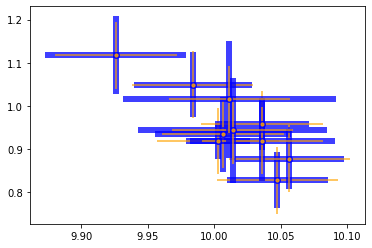

In [142]:
# Let's test these expressions
num_sensors = 5
base = 2.
delta_x = np.log(base)
sigma = 0.1*np.ones(num_sensors)
slope = 10.
intercept = 1.

num_tries = 10

z = base**(np.linspace(0, num_sensors - 1, num_sensors))
x = np.log(z/np.min(z))
y = np.polyval([slope, intercept], x)

for i in range(num_tries):
    noisy_y = y + normal(scale=sigma[0], size=num_sensors)

    popt, pcov = np.polyfit(x, noisy_y, 1, w=1/sigma, cov=True)
    unc = np.sqrt(np.diag(pcov))
    print(unc)
    
    plt.errorbar([popt[0], popt[0]], [popt[1], popt[1]], xerr=[unc[0], unc[0]], yerr=[unc[1], unc[1]], 
            marker='o', color='blue', alpha=0.5, lw=6)
       
    analytic_slope = calc_analytic_slope(delta_x, sigma, num_sensors, x, noisy_y)
    analytic_sigma_slope = calc_analytic_sigma_slope(delta_x, sigma, num_sensors)
    analytic_intercept = calc_analytic_intercept(delta_x, sigma, num_sensors, x, noisy_y)
    analytic_sigma_intercept = calc_analytic_sigma_intercept(delta_x, sigma, num_sensors)

    print(analytic_sigma_slope, analytic_sigma_intercept)
    
    plt.errorbar([analytic_slope, analytic_slope], 
                 [analytic_intercept, analytic_intercept], 
                 xerr=[analytic_sigma_slope, analytic_sigma_slope], 
                 yerr=[analytic_sigma_intercept, analytic_sigma_intercept], 
            marker='.', color='orange', alpha=0.5)

#     plt.errorbar([analytic_slope, analytic_slope], 
#                  [analytic_intercept, analytic_intercept], 
#             marker='.', color='orange', alpha=0.5)

# analytic_slope = calc_analytic_slope(delta_x, sigma, num_sensors, x, noisy_y)
# analytic_slope_sigma = calc_analytic_sigma_slope(delta_x, sigma, num_sensors)
# analytic_intercept = calc_analytic_intercept(delta_x, sigma, num_sensors, x, noisy_y)
# analytic_intercept_sigma = calc_analytic_sigma_intercept(delta_x, sigma, num_sensors)

# Sxx = calc_analytic_Sxx(delta_x, sigma[0], num_sensors)
# Delta = calc_analytic_Delta(delta_x, sigma[0], num_sensors)

# plt.fill_between([analytic_slope - analytic_slope_sigma, analytic_slope + analytic_slope_sigma], 
#                  [analytic_intercept - analytic_intercept_sigma, analytic_intercept - analytic_intercept_sigma],
#                  [analytic_intercept + analytic_intercept_sigma, analytic_intercept + analytic_intercept_sigma],
#                 alpha=0.5)

# numerical_slope = calc_slope(x, noisy_y, sigma)
# numerical_slope_sigma = sigma_slope(x, sigma)
# numerical_intercept = calc_intercept(x, noisy_y, sigma)
# numerical_intercept_sigma = sigma_intercept(x, sigma)

# plt.fill_between([numerical_slope - numerical_slope_sigma, numerical_slope + numerical_slope_sigma], 
#                  [numerical_intercept - numerical_intercept_sigma, numerical_intercept - numerical_intercept_sigma],
#                  [numerical_intercept + numerical_intercept_sigma, numerical_intercept + numerical_intercept_sigma],
#                 alpha=0.5)

$$
m = \frac{u_\star}{\kappa}\\
b = -\frac{u_\star}{\kappa} \ln \left( \frac{z_0}{z_\star} \right) = -m \ln \left( \frac{z_0}{z_\star} \right)
$$

$$
\sigma_{z_\star} = z_\star \frac{b}{m} \sqrt{ \left( \frac{\sigma_m}{m} \right)^2 + \left( \frac{\sigma_m}{b} \right)^2 - 2\left( \frac{\sigma_{bm}}{bm} \right) }
$$

In [15]:
def calc_analytic_sigma_intercept(delta_x, sigma, N):
    return np.sqrt(2.*sigma**2*(2*N - 1)/N/(N + 1))

def calc_analytic_sigma_slope(delta_x, sigma, N):
    return np.sqrt(12*sigma**2/delta_x**2/N/(N**2 - 1))

def calc_sigma_slope_intercept(delta_x, sigma, N):
    return 6*sigma[0]**2/N/(N + 1)/delta_x

def calc_sigma_intercept_slope(delta_x, sigma, N):
    return 6*sigma**2/N/(N + 1)/delta_x

def calc_sigma_ustar(delta_x, sigma, N, ustar, zstar, z0, kappa=0.4):
    m = calc_slope_from_star(ustar, zstar, z0, kappa=kappa)
    sigma_m = calc_analytic_sigma_slope(delta_x, sigma, N)
    
    return ustar/m*sigma_m

def calc_sigma_zstar(delta_x, sigma, N, ustar, zstar, z0, kappa=0.4):
    m = calc_slope_from_star(ustar, zstar, z0, kappa=kappa)
    b = calc_intercept_from_star(ustar, zstar, z0, kappa=kappa)
    
    sigma_m = calc_analytic_sigma_slope(delta_x, sigma, N)
    sigma_b = calc_analytic_sigma_intercept(delta_x, sigma, N)
    sigma_bm = calc_sigma_intercept_slope(delta_x, sigma, N)
    
    return zstar*np.abs(b/m)*np.sqrt((sigma_m/m)**2 + (sigma_b/b)**2 - 2*sigma_bm/b/m)

def calc_num_points(sample_time, sampling):
    return np.floor(sample_time/sampling)

def calc_slope_from_star(ustar, zstar, z0, kappa=0.4):
    return ustar/kappa

def calc_intercept_from_star(ustar, zstar, z0, kappa=0.4):
    return -ustar/kappa*np.log(z0/zstar)

def calc_wind_profile(z, ustar, zstar, kappa=0.4):
    return ustar/kappa*np.log(z/zstar)

4.0 0.9048374180359595



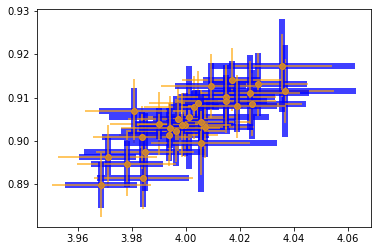

In [8]:
# Let's test these expressions
num_sensors = 5
base = 2.
delta_x = np.log(base)
sigma = 0.1*np.ones(num_sensors)
slope = 10.
intercept = 1.
kappa = 0.4

z = base**(np.linspace(0, num_sensors - 1, num_sensors))
x = np.log(z/np.min(z))
y = np.polyval([slope, intercept], x)

ustar = kappa*slope
zstar = np.min(z)*np.exp(-intercept/slope)

print(ustar, zstar)
print()

num_tries = 30

for i in range(num_tries):
    noisy_y = y + normal(scale=sigma[0], size=num_sensors)
    
    popt, pcov = curve_fit(calc_wind_profile, z, noisy_y, sigma=sigma, p0=[ustar, zstar])
    unc = np.sqrt(np.diag(pcov))

    plt.errorbar([popt[0], popt[0]], [popt[1], popt[1]], xerr=[unc[0], unc[0]], yerr=[unc[1], unc[1]], 
                marker='o', color='blue', alpha=0.5, lw=6)
    
    popt, pcov = np.polyfit(x, noisy_y, 1, w=1/sigma, cov=True)
#     sigma_bm = pcov[1,0]
#     unc = np.sqrt(np.diag(pcov))

    unc = [calc_analytic_sigma_slope(delta_x, sigma, num_sensors), 
           calc_analytic_sigma_intercept(delta_x, sigma, num_sensors)]
    sigma_bm = calc_cov(x, sigma)

    numerical_ustar = calc_ustar(*popt, np.min(z))
    numerical_sigma_ustar = calc_sigma_ustar(*popt, np.min(z), *unc, sigma_bm)
    numerical_zstar = calc_zstar(*popt, np.min(z))
    numerical_sigma_zstar = calc_sigma_zstar(*popt, np.min(z), *unc, sigma_bm)
    
    plt.errorbar([numerical_ustar, numerical_ustar], 
                 [numerical_zstar, numerical_zstar], 
                 xerr=[numerical_sigma_ustar, numerical_sigma_ustar], 
                 yerr=[numerical_sigma_zstar, numerical_sigma_zstar], 
            marker='o', color='orange', alpha=0.5)


4.0 0.9048374180359595

[0.01999711 0.00802181]
0.01824880919295551 0.00732048144689217
[0.01167441 0.00470437]
0.018248809192955507 0.007353619842139579
[0.0143454  0.00577453]
0.018248809192955507 0.007345793273620892
[0.02180889 0.00878455]
0.018248809192955507 0.0073505622873526995
[0.02284271 0.0092099 ]
0.018248809192955507 0.0073576938337850195
[0.00502923 0.00203102]
0.018248809192955507 0.007369648293069169
[0.01649513 0.00664983]
0.018248809192955507 0.0073568076415355555
[0.01880859 0.00761535]
0.018248809192955507 0.007388704596807816
[0.01103504 0.0044438 ]
0.018248809192955507 0.0073487745436629694
[0.02710943 0.01085613]
0.01824880919295551 0.0073078417409930705


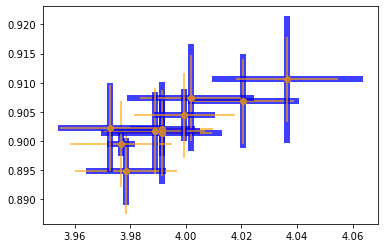

In [16]:
# But if I use polyfit's uncertainties, I recover ustar/zstar uncertainties that are consistent with curve_fit's.

# Let's test these expressions
num_sensors = 5
base = 2.
delta_x = np.log(base)
sigma = 0.1*np.ones(num_sensors)
slope = 10.
intercept = 1.
kappa = 0.4

z = base**(np.linspace(0, num_sensors - 1, num_sensors))
x = np.log(z/np.min(z))
y = np.polyval([slope, intercept], x)

ustar = kappa*slope
zstar = np.min(z)*np.exp(-intercept/slope)

print(ustar, zstar)
print()

num_tries = 10

for i in range(num_tries):
    noisy_y = y + normal(scale=sigma[0], size=num_sensors)
    
    popt, pcov = curve_fit(calc_wind_profile, z, noisy_y, sigma=sigma, p0=[ustar, zstar])
    unc = np.sqrt(np.diag(pcov))
    print(unc)

    plt.errorbar([popt[0], popt[0]], [popt[1], popt[1]], xerr=[unc[0], unc[0]], yerr=[unc[1], unc[1]], 
                marker='o', color='blue', alpha=0.5, lw=6)
    
    popt, pcov = np.polyfit(x, noisy_y, 1, w=1/sigma, cov=True)
    sigma_bm = pcov[1,0]
    unc = np.sqrt(np.diag(pcov))

    numerical_ustar = calc_ustar(*popt, np.min(z))
    numerical_zstar = calc_zstar(*popt, np.min(z))

    numerical_sigma_ustar = calc_sigma_ustar(delta_x, sigma[0], num_sensors, 
                                             numerical_ustar, numerical_zstar, np.min(z))
    numerical_sigma_zstar = calc_sigma_zstar(delta_x, sigma[0], num_sensors, 
                                             numerical_ustar, numerical_zstar, np.min(z))
    print(numerical_sigma_ustar, numerical_sigma_zstar)
    
    plt.errorbar([numerical_ustar, numerical_ustar], 
                 [numerical_zstar, numerical_zstar], 
                 xerr=[numerical_sigma_ustar, numerical_sigma_ustar], 
                 yerr=[numerical_sigma_zstar, numerical_sigma_zstar], 
            marker='o', color='orange', alpha=0.5)
